# Sobol indices

In [48]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from shapley.plots import set_style_paper, plot_sensitivity_results
set_style_paper()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gaussian Framework

In [2]:
from shapley.tests import AdditiveGaussian
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
theta = [0.0]
model.copula_parameters = theta

if True:
    dim = 3
    beta = None
    model = AdditiveGaussian(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.5]
    model.copula_parameters = theta

### Monte-Carlo estimation using true model

In [3]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_perms = None
n_var = 200
n_outer = 200
n_inner = 5

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 12200
Wall time: 2.32 s


In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 500
shapley_results = shapley.compute_indices(n_boot=n_boot)

Wall time: 201 ms


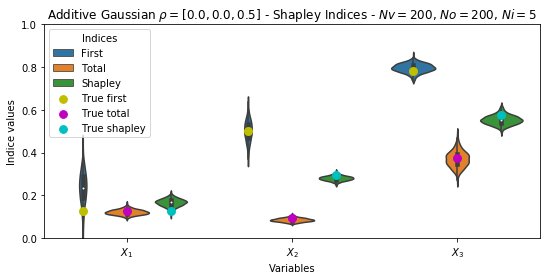

In [5]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Shapley Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(
    theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [6]:
X = np.asarray(model.get_input_sample(2000, 'monte-carlo'))
y = model(X)

In [7]:
%%time
from sklearn.ensemble import RandomForestRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices
n_tree = 100
rfq = RandomForestRegressor(n_estimators=n_tree, n_jobs=7)
rfq.fit(X, y)

Wall time: 275 ms


In [8]:
%%time
sobol_permutation = {}
for i, indice_type in enumerate(['full', 'ind']):
    sobol_permutation[indice_type] = compute_perm_indices(rfq, X, y, model.input_distribution, indice_type=indice_type)
    sobol_permutation[indice_type].true_first_indices = model.first_sobol_indices
    sobol_permutation[indice_type].true_total_indices = model.total_sobol_indices

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_

order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Par


Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params

order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.

order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Par

order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [0 1 2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1 2 0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2 0 1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Par

In [9]:
%%time
shapley_permutation = compute_shap_indices(rfq, X, y, model.input_distribution)

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_

order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Par

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [2,1,0]
order_cop:  [2, 1, 0]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [0,1,2]
order_cop:  [0, 1, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [0,2,1]
order_cop:  [1, 0, 2]
params_cop: [ 0.   0.   0.5]

Params:  [ 0.   0.   0.5]
order: [1,0,2]
order_cop:  [0, 2, 1]
params_cop: [ 0.   0.5  0. ]

Params:  [ 0.   0.   0.5]
order: [1,2,0]
order_cop:  [2, 0, 1]
params_cop: [ 0.5  0.   0. ]

Params:  [ 0.   0.   0.5]
order: [2,0,1]
order_cop:  [1, 2, 0]
params_

In [10]:
from shapley.indices import SensitivityResults
results_permutation = SensitivityResults()
results_permutation.first_indices = sobol_permutation['full']._first_indices
results_permutation.total_indices = sobol_permutation['ind']._total_indices
results_permutation.shapley_indices = shapley_permutation._shapley_indices
results_permutation.true_first_indices = model.first_sobol_indices
results_permutation.true_total_indices = model.total_sobol_indices
results_permutation.true_shapley_indices = model.shapley_indices

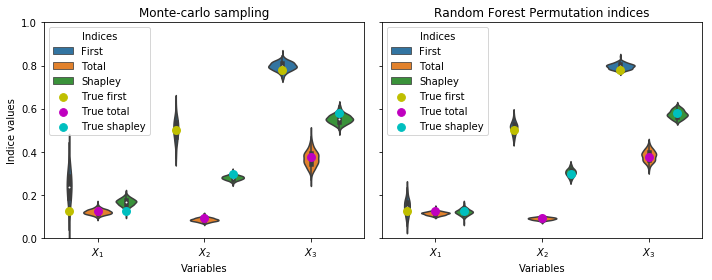

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
indice_type = 'full'
ax = axes[0]
plot_sensitivity_results(shapley_results, ax=ax)
ax.set_title('Monte-carlo sampling')
ax = axes[1]
plot_sensitivity_results(results_permutation, ax=ax)
ax.set_ylabel('')
ax.set_title('Random Forest Permutation indices')
ax.set_ylim(ylim)
fig.tight_layout()
fig.savefig('output/gaussian_montecarlo_vs_randomforest.pdf')

### Monte-Carlo estimation using a Kriging model

In [39]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(6111)
np.random.seed(6111)

model_budget = 10
sampling = 'lhs'
library = 'sklearn'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [40]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.90478329704


In [41]:
%%time
n_realization = 200
shapley.build_sample(model=model_gp, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

Wall time: 6min 57s


In [42]:
%%time
# Indice estimation
shapley_gp_results = shapley.compute_indices(n_boot=n_boot)

Wall time: 31.7 s


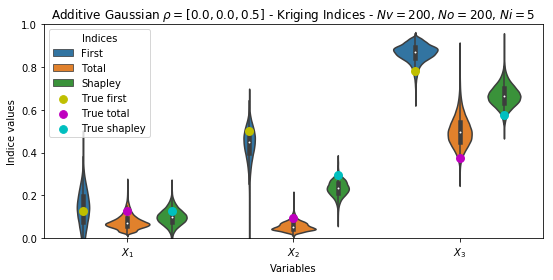

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(
    theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

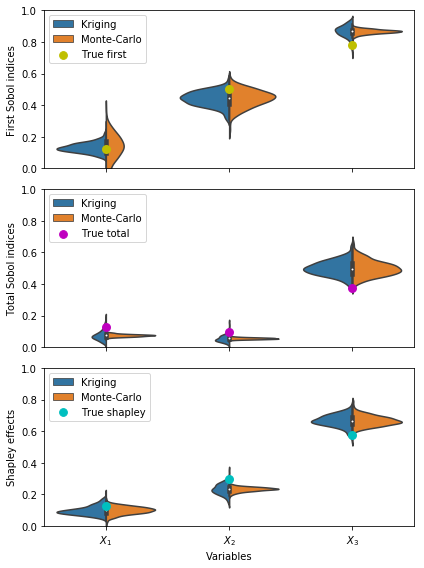

In [44]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_gp_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_gp_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_gp_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()

In [56]:
shapley_results.df_shapley_indices

,Variables,Indice values,Error
0,$X_{1}$,0.166007,Kriging
1,$X_{2}$,0.280158,Kriging
2,$X_{3}$,0.553835,Kriging
0,$X_{1}$,0.168703,Monte-Carlo
1,$X_{1}$,0.166817,Monte-Carlo
2,$X_{1}$,0.177481,Monte-Carlo
3,$X_{1}$,0.168459,Monte-Carlo
4,$X_{1}$,0.141030,Monte-Carlo
5,$X_{1}$,0.173198,Monte-Carlo
6,$X_{1}$,0.153538,Monte-Carlo


ValueError: Could not interpret input 'Indices'

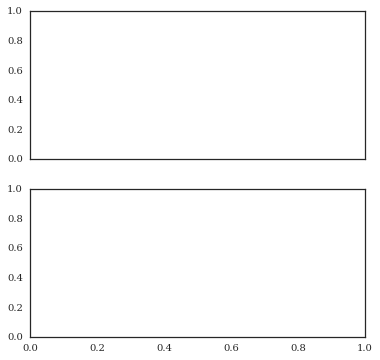

In [58]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_xlabel('')
ax.set_ylim(ylim)

ax = axes[1]
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_ylim(ylim)
ax.legend([])
fig.tight_layout()
fig.savefig('./output/shapleyGP_additive_gaussian.pdf')

### Monte-Carlo estimation using a Random Forest model

In [ ]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_rf.build(n_realization, method='random-forest')

In [ ]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_rf)

In [ ]:
%%time
shapley.build_sample(model=model_rf, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

In [ ]:
%%time
shapley_rf_results = shapley.compute_indices(n_boot=n_boot)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_rf_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(
    theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_rf_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_rf_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_rf_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()